In [1]:
%cd ..

/mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn


In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
import os
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
import amber
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model

Using TensorFlow backend.


In [3]:
from src.data import load_finkelstein_data as get_data
%matplotlib inline

In [4]:
wd = "outputs/CNN-wtCas9_cleave_rate_log-0/"
target = "wtCas9_cleave_rate_log"

res = get_data(target=target, logbase=10)
# unpack data tuple
(x_train, y_train), (x_test, y_test) = res

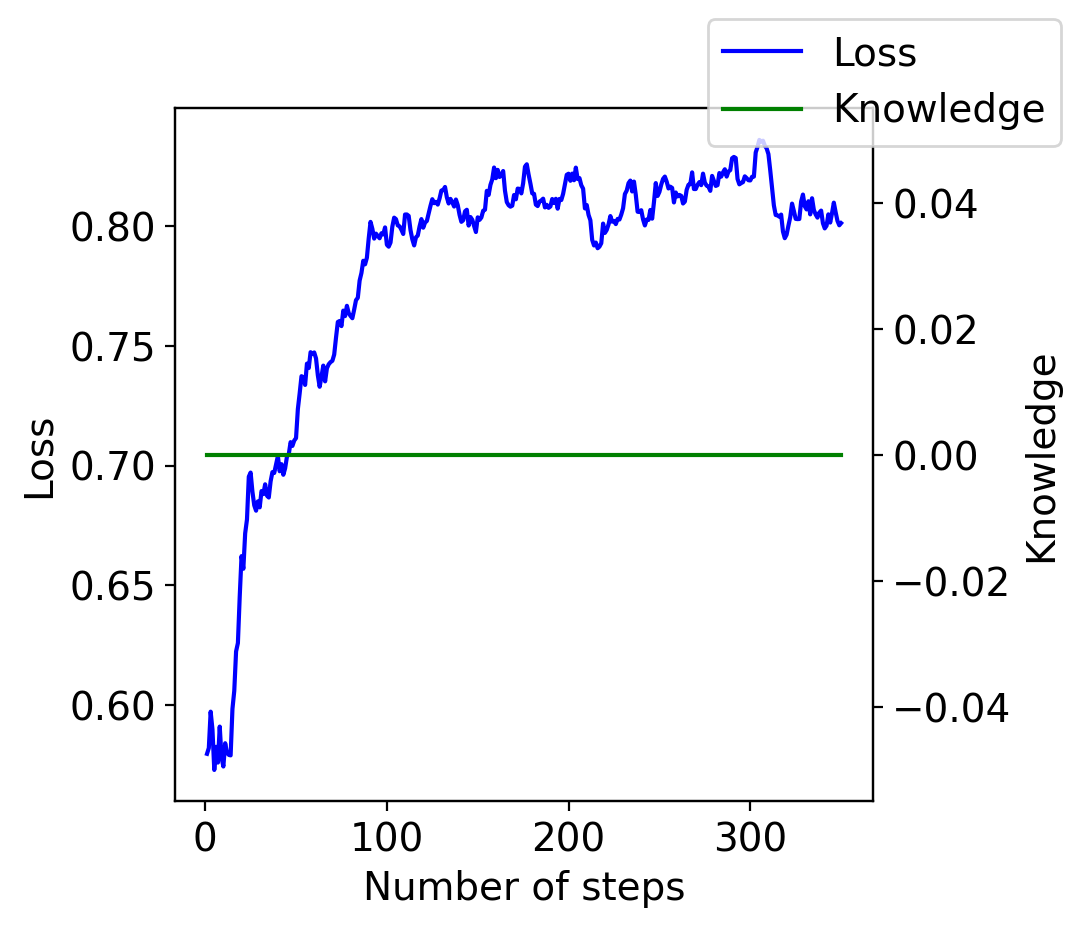

In [5]:
from IPython.display import Image

Image(filename=os.path.join(wd, "nas_training_stats.png"), width=400)

/mnt/home/zzhang/anaconda3/envs/amber-dev/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  import sys
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


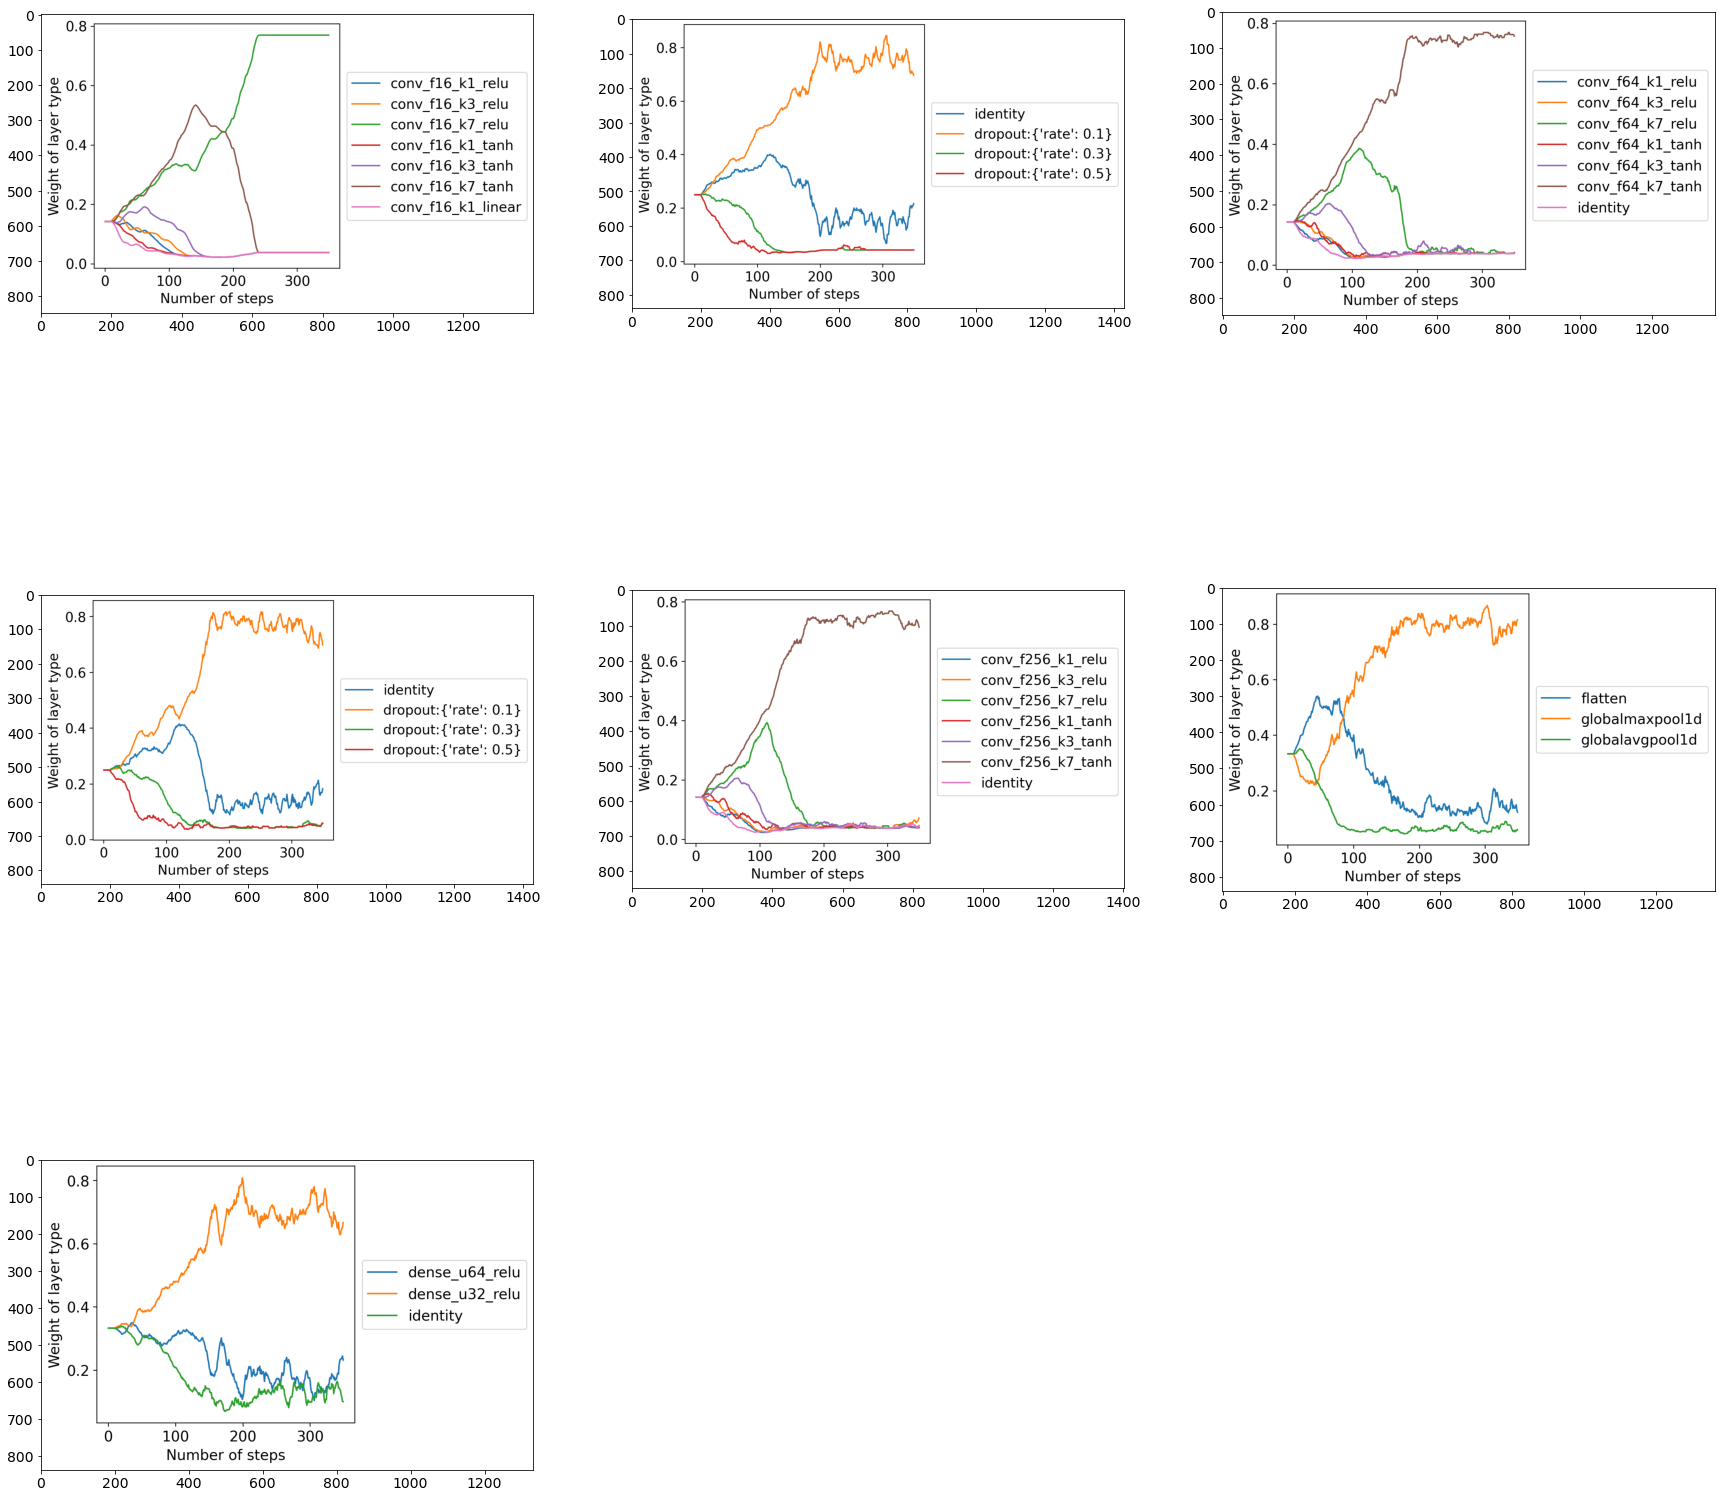

In [6]:
import matplotlib.image as mpimg

plt.figure(figsize=(30,30))
columns = 3
images = [mpimg.imread(os.path.join(wd,x)) for x in sorted([x for x in os.listdir(wd) if x.startswith("weight_at") and x.endswith("png")])]
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)

In [7]:
train_hist = pd.read_table(os.path.join(wd, "train_history.csv"), sep=",", header=None)
train_hist.sort_values(2, ascending=False)

,0,1,2,3,4,5,6,7,8,9
2105,2105,"[0, 0.8801139534967202]",0.880114,2,1,5,1,5,2,1
3347,3347,"[0, 0.8797442190654601]",0.879744,2,2,5,1,5,2,1
1027,1027,"[0, 0.8772697111636919]",0.877270,2,2,5,1,5,2,1
2560,2560,"[0, 0.8740160581481776]",0.874016,2,1,5,1,5,2,1
2752,2752,"[0, 0.8737119335295103]",0.873712,2,1,5,1,5,2,1
...,...,...,...,...,...,...,...,...,...,...
80,80,"[0, 0.13544364002126186]",0.135444,0,2,6,3,1,1,1
1650,1650,"[0, 0.1334070547519717]",0.133407,6,3,6,0,5,1,1
15,15,"[0, 0.09665540343807495]",0.096655,6,3,6,2,0,1,2
137,137,"[0, 0.08105447689237331]",0.081054,4,2,0,0,6,1,0


In [8]:
best_trial_id = train_hist.sort_values(2, ascending=False).head(1)[0]
model = tf.keras.models.load_model(os.path.join(wd, "weights", "trial_%i"%best_trial_id, "bestmodel.h5"))

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 25, 9)]           0         
_________________________________________________________________
conv0 (Conv1D)               (None, 19, 16)            1024      
_________________________________________________________________
dropout (Dropout)            (None, 19, 16)            0         
_________________________________________________________________
conv1 (Conv1D)               (None, 13, 64)            7232      
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 64)            0         
_________________________________________________________________
conv2 (Conv1D)               (None, 7, 256)            114944    
_________________________________________________________________
global_average_pooling1d (Gl (None, 256)               0     

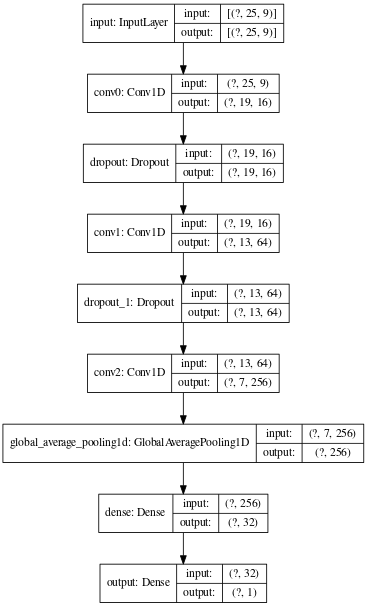

In [10]:
plot_model(model, show_shapes=True, show_layer_names=True, dpi=60)

In [11]:
model.compile(loss="mse", optimizer="adam")

In [12]:
retrain = False
if retrain:
    checkpointer = ModelCheckpoint(filepath="bestmodel.h5", mode='min', verbose=0, save_best_only=True,
                           save_weights_only=True)
    earlystopper = EarlyStopping(
        monitor="val_loss",
        mode='min',
        patience=20,
        verbose=0)

    hist = model.fit(x_train,
              y_train,
              batch_size=32,
              callbacks=[checkpointer, earlystopper],
              validation_data=(x_test, y_test),
              epochs=500,
              verbose=2)
    model.load_weights('bestmodel.h5')
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

/mnt/home/zzhang/anaconda3/envs/amber-dev/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


spearman SpearmanrResult(correlation=0.7981709954142491, pvalue=0.0)
pearson (0.8809701590351372, 0.0)


Text(0.5, 0.98, 'Testing prediction, pcc=0.881')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


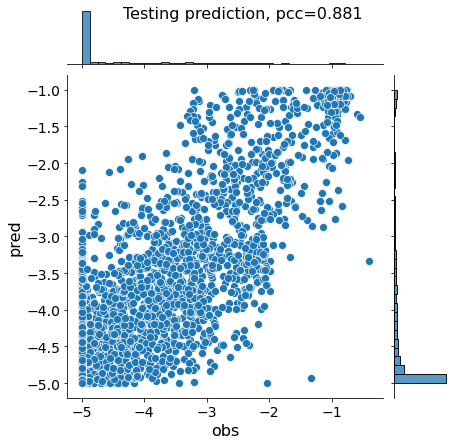

In [13]:
y_hat = model.predict(x_test).flatten()
y_hat = np.clip(y_hat, -5, -1)
h = sns.jointplot(y_test, y_hat)
h.set_axis_labels("obs", "pred", fontsize=16)
print("spearman", ss.spearmanr(y_hat, y_test))
p = ss.pearsonr(y_hat, y_test)
print("pearson", p)
h.fig.suptitle("Testing prediction, pcc=%.3f"%p[0], fontsize=16)

/mnt/home/zzhang/anaconda3/envs/amber-dev/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


spearman SpearmanrResult(correlation=0.8771326429217274, pvalue=0.0)
pearson (0.9622410864334583, 0.0)


Text(0.5, 0.98, 'sgRNA 1 - Train fit,\npcc=0.962, n=6988')

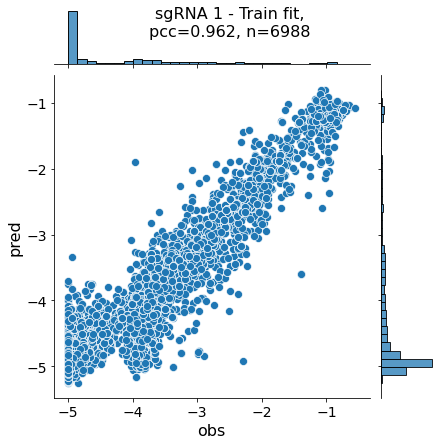

In [14]:
y_fit = model.predict(x_train).flatten()
h = sns.jointplot(y_train, y_fit)
h.set_axis_labels("obs", "pred", fontsize=16)
print("spearman", ss.spearmanr(y_fit, y_train))
p = ss.pearsonr(y_fit, y_train)
print("pearson", p)
h.fig.suptitle("sgRNA 1 - Train fit,\npcc=%.3f, n=%i"%(p[0], len(y_fit)), fontsize=16)

In [15]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Aug 30 2022

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.22.0

scipy     : 1.7.3
tensorflow: 1.15.0
amber     : 0.1.2
matplotlib: 3.4.3
pandas    : 1.3.5
numpy     : 1.21.6
seaborn   : 0.11.1

Watermark: 2.3.1

